In [108]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

# Time Series Libaries
from statsmodels.tsa.ar_model import AR
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

#Useful stuff
import scipy
import datetime as dt
import numpy as np
from pandas import concat


# Error Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline  

from pandas.plotting import autocorrelation_plot


In [109]:
ita_df = pd.read_csv("Sea arrivals by day_ITA.csv", sep = ";", index_col=0,parse_dates=True, header=0,dayfirst=True)
#ita_df = pd.read_csv("Sea arrivals by day_ITA.csv", sep = ";", header=0)

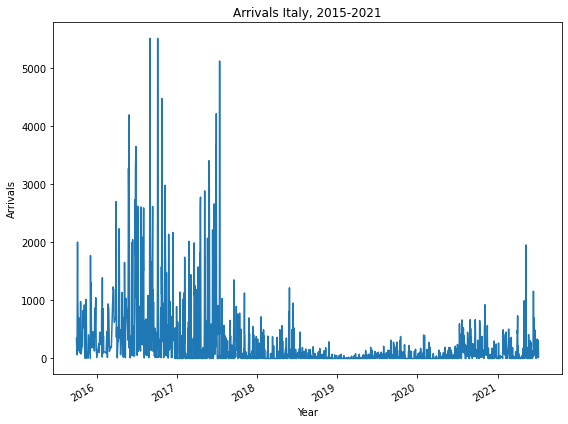

In [110]:
fig, ax = plt.subplots(figsize=(8,6));

ita_df['individuals'].plot(ax=ax);

ax.set_title('Arrivals Italy, 2015-2021');
ax.set_ylabel('Arrivals');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout()

In [111]:
# Plotting of relevant Acf pacf Data to determine the Order of the SARIMA and Arima Modell
def tsplot(y, lags=None, title='', figsize=(14, 8)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<AxesSubplot:title={'center':'Arrivals of individuals in Italy'}, xlabel='Date'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

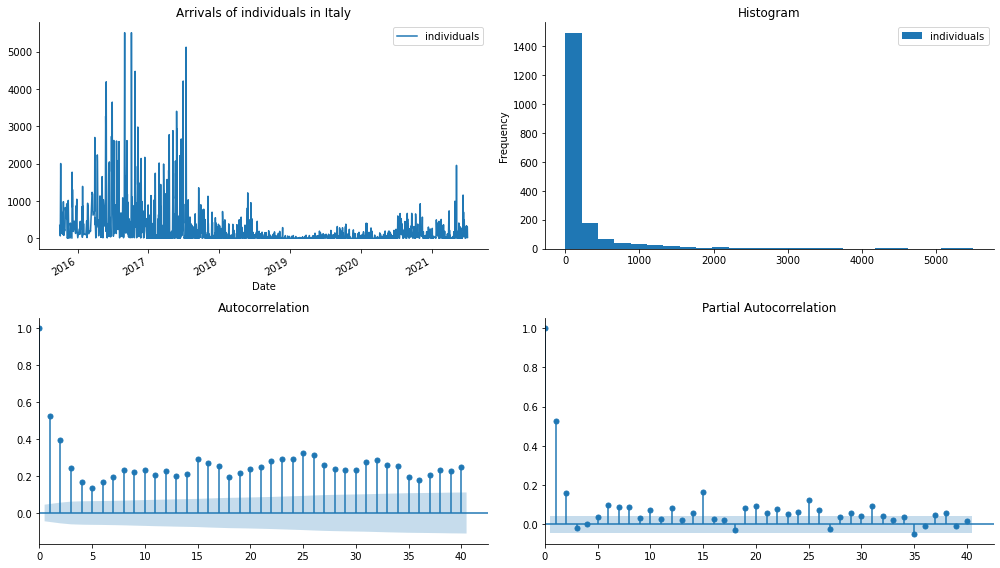

In [112]:
tsplot(ita_df, title="Arrivals of individuals in Italy",lags=40)

In [113]:
#ita_ln_diff.isna().sum()
#ita_df["individuals"] = ita_df["individuals"].fillna(0)
ita_df["individuals"].isnull().sum()
ita_df.max()

individuals    5504
dtype: int64

In [114]:
type(ita_df)

pandas.core.frame.DataFrame

In [115]:
ita_df.head()

,individuals
Date,
2015-10-01,343
2015-10-03,128
2015-10-04,62
2015-10-06,2001
2015-10-07,1010


In [116]:
ita_df

,individuals
Date,
2015-10-01,343
2015-10-03,128
2015-10-04,62
2015-10-06,2001
2015-10-07,1010
...,...
2021-07-01,322
2021-07-02,12
2021-07-03,308


In [117]:
# freq missing
ita_df.index

DatetimeIndex(['2015-10-01', '2015-10-03', '2015-10-04', '2015-10-06',
               '2015-10-07', '2015-10-09', '2015-10-10', '2015-10-11',
               '2015-10-12', '2015-10-14',
               ...
               '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29',
               '2021-06-30', '2021-07-01', '2021-07-02', '2021-07-03',
               '2021-07-04', '2021-07-05'],
              dtype='datetime64[ns]', name='Date', length=1903, freq=None)

In [118]:
ita_df.columns

Index(['individuals'], dtype='object')

In [119]:
#ita_df.index = pd.to_datetime(ita_df.index).strftime('%Y-%d-%m')

In [120]:
type(ita_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [121]:

ita_df_M = ita_df.individuals.resample("M").sum()

In [122]:
ita_df_W = ita_df.individuals.resample("W").sum()

In [123]:
ita_df_D= ita_df.individuals.resample("D").sum()

<AxesSubplot:xlabel='Date'>

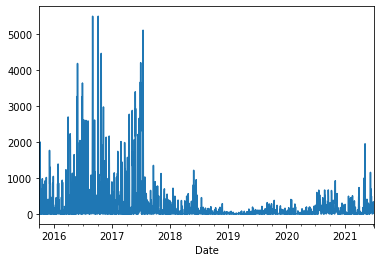

In [124]:
ita_df_D.plot()

<AxesSubplot:xlabel='Date'>

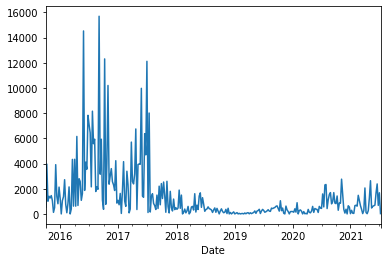

In [125]:
ita_df_W.plot()

<AxesSubplot:xlabel='Date'>

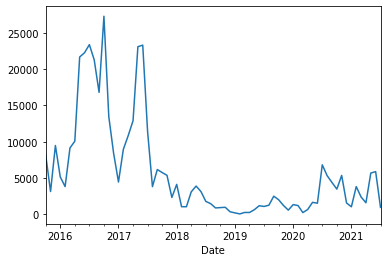

In [126]:
ita_df_M.plot()

In [127]:
decompose_ita_M= sm.tsa.seasonal_decompose(ita_df_M, model="additive")
decompose_ita_W= sm.tsa.seasonal_decompose(ita_df_W, model="additive")
decompose_ita_D= sm.tsa.seasonal_decompose(ita_df_D, model="additive")

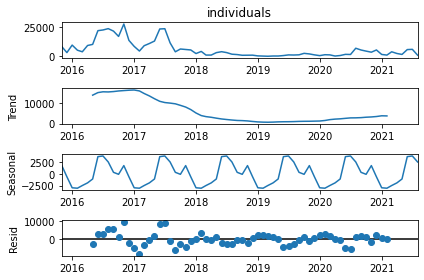

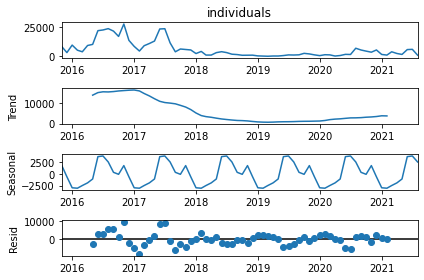

In [128]:
decompose_ita_M.plot()

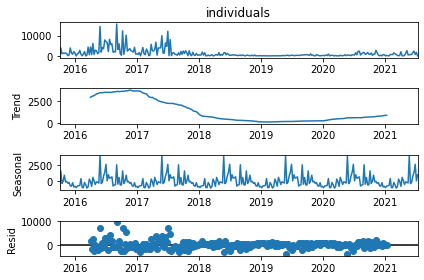

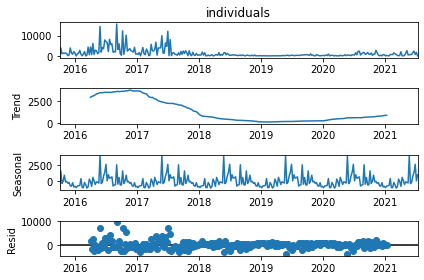

In [129]:
decompose_ita_W.plot()

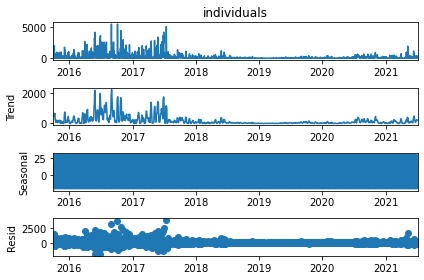

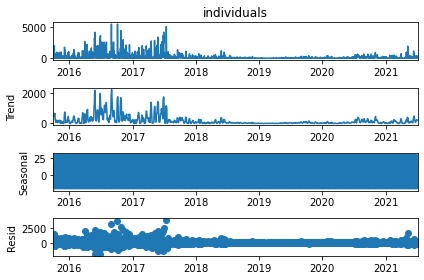

In [130]:
decompose_ita_D.plot()

In [131]:
ita_df_diff_M = ita_df_M.diff(periods=1)
ita_df_diff_W = ita_df_W.diff(periods=1)
ita_df_diff_D = ita_df_D.diff(periods=1)

In [132]:

ita_df_diff_M = ita_df_diff_M[1:]
ita_df_diff_W = ita_df_diff_W[1:]
ita_df_diff_D = ita_df_diff_D[1:]

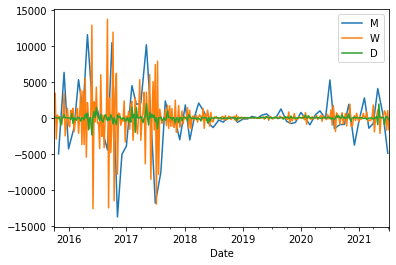

In [133]:
ita_df_diff_M.plot()
ita_df_diff_W.plot()
ita_df_diff_D.plot().legend("MWD")



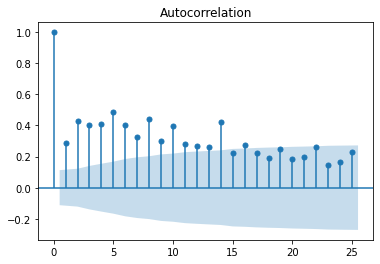

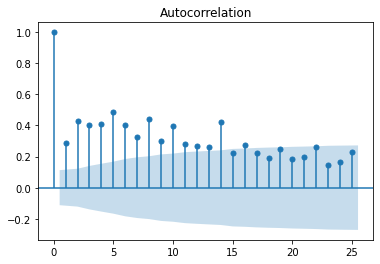

In [134]:
plot_acf(ita_df_W)


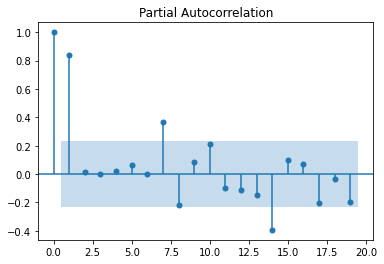

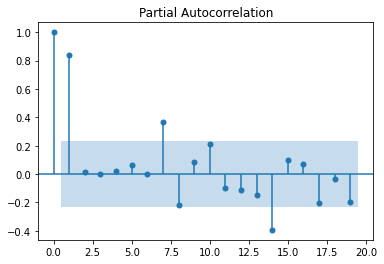

In [135]:
plot_pacf(ita_df_M)

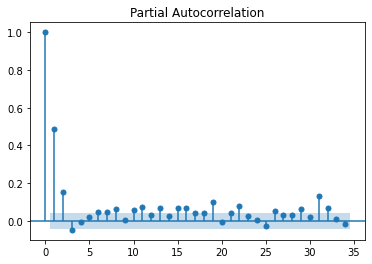

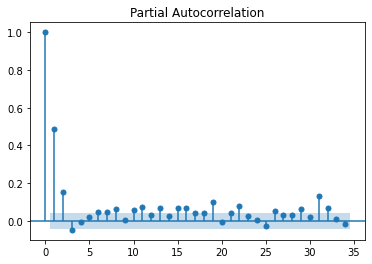

In [136]:
plot_pacf(ita_df_D)

## Train Test Split des Datensatzes

In [137]:
ita_df_W.shape


(302,)

In [138]:
ita_df_w_same= ita_df_W["2018-06-25":"2020-06-29"]

In [139]:
ita_df_w_same.shape

(105,)

Splitt Data into Train, Test

In [140]:
# Kompletter Datensatz
train_set, test_set= np.split(ita_df_W, [int(.80 *len(ita_df_W))])
train_set.shape

(241,)

In [141]:
# Datenanfang gleich wie bei iom_weekly_model Marco
train_set_same, test_set_same= np.split(ita_df_w_same, [int(.80 *len(ita_df_w_same))])
train_set_same.head()

Date
2018-07-01    211
2018-07-08    345
2018-07-15    395
2018-07-22    561
2018-07-29    421
Freq: W-SUN, Name: individuals, dtype: int64

In [142]:
# Daily Daten Gesamter Datensatz
train_set_d, test_set_d= np.split(ita_df_D, [int(.80 *len(ita_df_D))])

In [253]:
train_set_monthly, test_set_monthly= np.split(ita_df_D, [int(.80 *len(ita_df_M))])

In [143]:
test_set_same.head()

Date
2020-02-09      0
2020-02-16    274
2020-02-23    316
2020-03-01    212
2020-03-08      0
Freq: W-SUN, Name: individuals, dtype: int64

In [144]:
from statsmodels.tsa.ar_model import AutoReg

In [145]:
# Helper Funktion um Modelle zu Plotten und zu evaluieren --> Exogen falls Multivariater Input verwendet wird
def fit_plot_evaluate(model, trainset, testset, exogen = None):
    
    if  exogen is not None:
        fit = model.fit()
        predict = fit.predict(start=len(trainset), end=len(trainset)+len(testset)-1,exog = exogen, dynamic = False)
        
        # In der Zeitreihenanalyse werden negative Werte mit 0 ersetzt, da es für den Forecast in unserem Use Case keinen Sinn macht
        predict = predict.apply(lambda x : x if x > 0 else 0)
        testset.plot()
        predict.plot()
        mean_squared_Error = sqrt(mean_squared_error(testset["individuals"], predict))
        precentage_error = mean_absolute_percentage_error(testset["individuals"], predict)
        
        
    else:
        fit = model.fit()
        predict = fit.predict(start=len(trainset), end=len(trainset)+len(testset)-1, dynamic = False)
        # In der Zeitreihenanalyse werden negative Werte mit 0 ersetzt, da es für den Forecast in unserem Use Case keinen Sinn macht
        predict = predict.apply(lambda x : x if x > 0 else 0)
        testset.plot()
        predict.plot()
        mean_squared_Error = sqrt(mean_squared_error(testset, predict))
        precentage_error = mean_absolute_percentage_error(testset, predict) 
        
        

    
    return mean_squared_Error, precentage_error

In [190]:
from contextlib import suppress


# Um den besten Lag Parameter zu finden nutzen wir diese Funktion
def find_best_lag(traindata, testdata):
    results =[]
    try:
        for i in range(0,25):
            AR_Modell_same_t = AutoReg(traindata, lags = i, seasonal = True, old_names=False)
            AR_fit_t = AR_Modell_same_t.fit()
            prediction = AR_fit_t.predict(start=len(traindata), end=len(traindata)+len(testdata)-1, dynamic = False)
            prediction = prediction.apply(lambda x : x if x > 0 else 0)
            error = sqrt(mean_squared_error(testdata, prediction))
            results.append(error)
            #print("RMSE: ", error, i)
            # Falls RMSE in der Liste am Kleinsten  speichern wir i in einer Variable und geben sie aus
            if error == min(results):
                best_lag = i
        print("Bester Lag: ", best_lag, " RMSE: ", min(results))
# division by 0 Error handling
    except:
        print("Bester Lag: ", best_lag , " RMSE: ", min(results))

    

In [191]:
# Beste Lags für daily Daten
find_best_lag(train_set_d,test_set_d)

Bester Lag:  23  RMSE:  207.29450983544078


In [192]:
# Beste Lags für Weekly
find_best_lag(train_set,test_set)

Bester Lag:  23  RMSE:  1434.2626628878097


In [193]:
# Beste Lags für Weekly Marco Daten
find_best_lag(train_set_same, test_set_same)

Bester Lag:  4  RMSE:  156.61112067960096


C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\regression\linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


## Als Baselinemodell nutzen wir das Autoregressive Modell, da es von allen das einfachste ist:

In [194]:
# Lags how many past observations should be considered in the Modell
AR_Modell = AutoReg(train_set, lags = 23, seasonal = True)

C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [195]:
AR_Modell_same = AutoReg(train_set_same, lags = 4, seasonal = True)


C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [71]:
AR_Modell_d = AutoReg(train_set_d, lags = 23, seasonal = True)

C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


(156.61112067960096, 1.3012732042948672e+17)

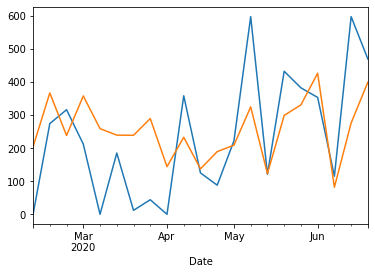

In [196]:
fit_plot_evaluate(AR_Modell_same, train_set_same, test_set_same)

(207.29450983544078, 3.028362106429383e+17)

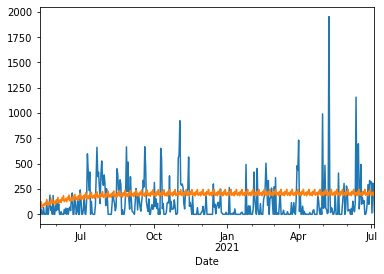

In [197]:
fit_plot_evaluate(AR_Modell_d,train_set_d,test_set_d)

(1434.2626628878097, 5.0674911955571544e+16)

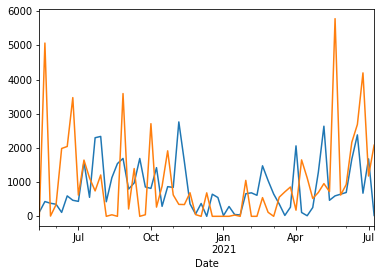

In [199]:
#Angepasster Datensatz
fit_plot_evaluate(AR_Modell,train_set,test_set)

Wir sehen, dass die Vorhersage mit den Daten ab 2017 genauer ist im Vergleich zur Vorhersage mit dem gesamten Datensatz


## ARIMA test 
# Hypothese : Da es sich um Seasonal Daten handelt sollte dieses Modell sehr schlechte Ergebnisse liefern, da es die Seasonale Komponente der Zeitreihe nicht erfassen kann

In [200]:
arima_model_ita = ARIMA(train_set_same, order=(1,1,0))


C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(286.4431846283178, 0.7576835383407391)

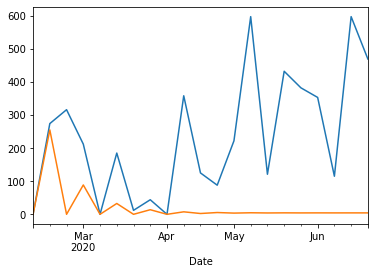

In [201]:
fit_plot_evaluate(arima_model_ita,train_set_same,test_set_same)

# SARIMA:




In [202]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Trend
- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

# Seasonal

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.


In [203]:
#Sarima_Modell = SARIMAX(train_set,order = (2,1,0), seasonal_order=(1,2,1,12))
Sarima_Modell_same = SARIMAX(train_set_same,order = (2,1,0), seasonal_order=(0,1,0,6))

In [54]:
train_set_same.isnull().sum()

0

(1080.1746275507494, 4.4550174415428794e+17)

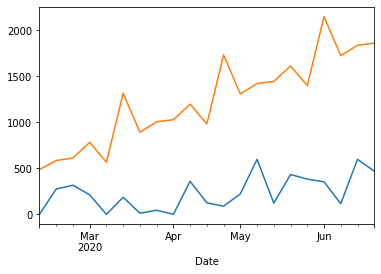

In [204]:
fit_plot_evaluate(Sarima_Modell_same, train_set_same, test_set_same)

In [269]:
def rolling_forecast(traindata,test_data, Modell_order = None):
    history = [x for x in traindata]
    predictions = list()
  
    for t in range(len(test_data)):
        Sarima_Modell_same = SARIMAX(history,order = Modell_order ,seasonal_order=(0,0,0,0))
        model_fit = Sarima_Modell_same.fit()
        output = model_fit.forecast(steps = 100)
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    
    series_predicted = pd.Series(predictions, dtype='float64')
    series_predicted.index = test_data.index
    
    test_data.plot()
    series_predicted.plot()

    print(sqrt(mean_squared_error(test_data, series_predicted)))
    


202.0233650431206


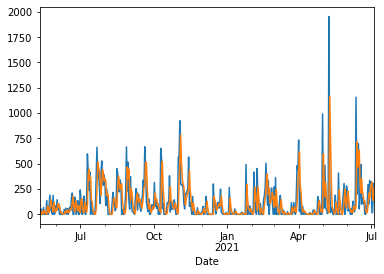

In [274]:
rolling_forecast(train_set_d,test_set_d,(2,0,0))

204.2427713766881


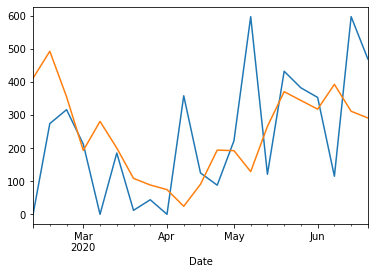

In [273]:
rolling_forecast(train_set_same, test_set_same, (2,1,0))

790.0281385321592


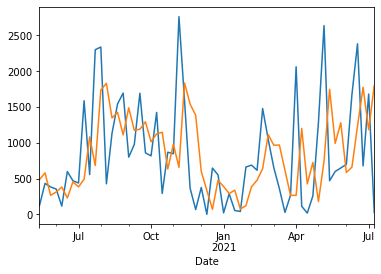

In [245]:
rolling_forecast(train_set, test_set, (2,1,0))

444.6452374359691


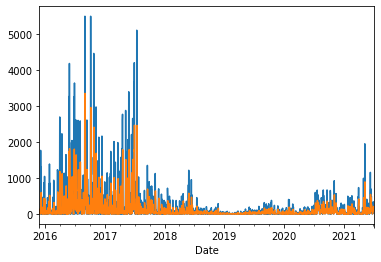

In [275]:
rolling_forecast(train_set_monthly, test_set_monthly, (2,0,0))

In [251]:
Sarima_fit_same = Sarima_Modell_same.fit()
Sarima_fit_same.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          individuals   No. Observations:                  126
Model:             SARIMAX(2, 1, 0)x(1, 2, [1], 12)   Log Likelihood                -818.269
Date:                              Wed, 21 Jul 2021   AIC                           1646.539
Time:                                      16:32:32   BIC                           1659.614
Sample:                                  06-25-2017   HQIC                          1651.832
                                       - 11-17-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6726      0.074     -9.067      0.000      -0.818      -0.527
ar.L2         -0.2060      0.061     -3.361      0.001      -0.326      -0.086
ar.S.L12      -0.2871      0.054     -5.324      0.000      -0.393      -0.181
ma.S.L12      -0.9897      0.117     -8.462      0.000      -1.219      -0.760
sigma2      6.457e+05   1.82e-07   3.55e+12      0.000    6.46e+05    6.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.30
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.68e+27. Standard errors may be unstable.
"""

In [252]:
#prediction = Sarima_fit.predict(start=len(train_set), end=len(train_set)+len(test_set)-1)
prediction_same = Sarima_fit_same.predict(start=len(train_set_same), end=len(train_set_same)+len(test_set_same)-1)



<AxesSubplot:xlabel='Date'>

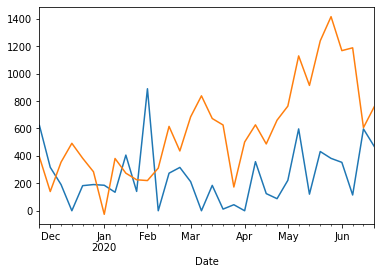

In [253]:
# Same data as git repo
test_set_same.plot()
prediction_same.plot()


In [254]:
from sklearn.metrics import mean_absolute_percentage_error

In [255]:
# Datenquellen vergleichen

# Adding Weather Data
## Using mean max Temperature as a exogenous variable

In [291]:
weather_ita = pd.read_csv("Tripoli_Weahter_Data.csv", sep = ",", dayfirst=True)


In [292]:
weather_ita["Date"] = pd.to_datetime((weather_ita.YEAR*10000+weather_ita.MO*100+weather_ita.DY).apply(str),format='%Y%m%d')

In [293]:
weather_ita = weather_ita.set_index("Date")

In [294]:
weather_ita

,LAT,LON,YEAR,MO,DY,T2M_RANGE,TS,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M,WS50M_RANGE,WS10M_RANGE,WS50M_MIN,WS10M_MIN,WS50M_MAX,WS10M_MAX,WS50M,WS10M
Date,,,,,,,,,,,,,,,,,,,,
2015-01-01,32.89941,13.20261,2015,1,1,5.94,11.20,5.05,5.06,11.70,5.75,8.74,7.53,6.73,7.51,6.17,15.04,12.90,10.59,8.77
2015-01-02,32.89941,13.20261,2015,1,2,2.42,13.34,7.09,7.10,13.74,11.31,12.14,3.40,2.80,7.84,5.76,11.24,8.57,9.42,7.46
2015-01-03,32.89941,13.20261,2015,1,3,3.90,13.39,8.12,8.12,14.58,10.68,12.62,1.66,1.34,7.24,5.35,8.90,6.69,8.13,6.19
2015-01-04,32.89941,13.20261,2015,1,4,7.52,12.98,5.82,5.84,15.92,8.40,11.94,4.28,3.92,8.19,6.49,12.47,10.41,10.89,8.92
2015-01-05,32.89941,13.20261,2015,1,5,6.39,13.53,8.51,8.51,16.40,10.00,12.98,3.23,3.45,8.23,5.98,11.46,9.43,9.87,7.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-15,32.89941,13.20261,2021,7,15,6.71,29.46,19.01,23.26,31.35,24.64,27.51,3.97,4.08,2.09,1.48,6.06,5.56,4.88,4.25
2021-07-16,32.89941,13.20261,2021,7,16,9.12,29.74,18.33,23.02,33.09,23.97,27.71,6.16,5.89,0.80,0.68,6.96,6.57,3.77,3.38
2021-07-17,32.89941,13.20261,2021,7,17,5.87,28.34,18.05,22.16,29.68,23.81,26.28,7.14,6.76,1.21,0.95,8.35,7.71,5.18,4.49


In [295]:
combined_df_test = weather_ita.merge(ita_df_w_same, left_index=True, right_index=True)

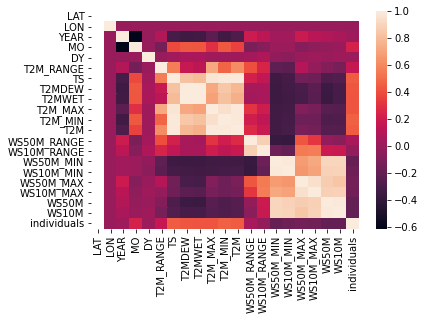

In [296]:
corr = combined_df_test.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [317]:
weather_ita["T2M_Weekly"]=weather_ita["T2M"].resample("W").mean()
weather_ita["TS_Weekly"]=weather_ita["TS"].resample("W").mean()

In [318]:
weather_ita = weather_ita.asfreq("W")

In [319]:
weather_ita

,T2M_RANGE,TS,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M,WS50M_RANGE,WS10M_RANGE,WS50M_MIN,WS10M_MIN,WS50M_MAX,WS10M_MAX,WS50M,WS10M,T2M_Weekly,TS_Weekly
Date,,,,,,,,,,,,,,,,,
2015-01-04,7.52,12.98,5.82,5.84,15.92,8.40,11.94,4.28,3.92,8.19,6.49,12.47,10.41,10.89,8.92,11.94,12.98
2015-01-11,7.80,13.12,5.75,5.77,16.95,9.15,12.49,3.13,2.81,7.34,4.95,10.47,7.76,8.52,6.52,12.49,13.12
2015-01-18,9.69,14.71,5.67,5.69,20.56,10.86,14.65,3.01,1.88,6.51,5.44,9.52,7.32,8.39,6.14,14.65,14.71
2015-01-25,6.72,11.75,3.70,3.72,14.49,7.77,10.75,4.63,5.01,7.24,4.79,11.87,9.80,9.84,7.72,10.75,11.75
2015-02-01,6.77,14.63,5.88,5.90,17.63,10.86,14.89,6.13,4.01,9.09,7.49,15.22,11.50,11.13,8.60,14.89,14.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-20,11.80,30.15,12.15,21.39,36.96,25.15,30.63,8.61,4.62,0.03,0.24,8.65,4.86,5.38,3.58,30.63,30.15
2021-06-27,11.31,32.70,11.27,22.28,38.74,27.43,33.28,6.93,3.93,3.57,2.86,10.51,6.79,7.44,5.10,33.28,32.70
2021-07-04,12.52,33.02,14.19,23.84,39.52,26.99,33.49,5.16,3.18,1.28,1.02,6.44,4.19,4.02,2.95,33.49,33.02


In [300]:
weather_ita = weather_ita.drop(["LAT","LON","YEAR","MO","DY"], axis = 1)

In [320]:
weather_ita.index = pd.to_datetime(weather_ita.index)

In [321]:
weather_ita_adjusted = weather_ita["2017-06-25":"2020-06-28"]

In [322]:
weather_ita_adjusted

,T2M_RANGE,TS,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M,WS50M_RANGE,WS10M_RANGE,WS50M_MIN,WS10M_MIN,WS50M_MAX,WS10M_MAX,WS50M,WS10M,T2M_Weekly,TS_Weekly
Date,,,,,,,,,,,,,,,,,
2017-06-25,11.36,27.60,12.78,12.80,31.52,20.16,26.07,4.47,3.46,1.89,1.65,6.36,5.10,4.80,3.61,26.07,27.60
2017-07-02,5.29,27.54,18.40,18.40,28.83,23.54,25.90,2.57,2.68,6.65,5.67,9.23,8.35,8.40,7.27,25.90,27.54
2017-07-09,11.69,29.87,13.73,13.74,33.80,22.10,28.06,6.36,4.50,2.04,1.83,8.41,6.33,5.07,3.95,28.06,29.87
2017-07-16,7.54,27.53,19.63,19.63,29.38,21.84,25.41,5.51,5.73,3.31,2.33,8.82,8.07,5.92,5.06,25.41,27.53
2017-07-23,11.33,32.26,12.44,12.44,37.39,26.06,31.54,6.91,5.02,1.10,0.97,8.02,5.99,4.73,3.51,31.54,32.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31,8.00,24.47,16.07,15.83,27.24,19.24,22.83,3.62,3.84,2.27,1.26,5.88,5.09,4.03,3.33,22.83,24.47
2020-06-07,15.77,28.54,11.30,10.77,35.89,20.12,28.46,10.13,6.95,2.29,1.84,12.42,8.79,6.53,4.84,28.46,28.54
2020-06-14,9.54,26.62,16.17,15.40,30.72,21.18,25.56,8.87,6.64,3.99,3.28,12.85,9.92,8.15,6.66,25.56,26.62


# Combining both Dataframes

In [324]:
combined_df = weather_ita_adjusted.merge(ita_df_w_same, left_index=True, right_index=True)

In [325]:
combined_df

,T2M_RANGE,TS,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M,WS50M_RANGE,WS10M_RANGE,WS50M_MIN,WS10M_MIN,WS50M_MAX,WS10M_MAX,WS50M,WS10M,T2M_Weekly,TS_Weekly,individuals
Date,,,,,,,,,,,,,,,,,,
2018-07-01,11.64,31.09,14.12,13.06,37.06,25.42,30.61,8.13,5.35,0.96,1.06,9.09,6.40,4.92,3.61,30.61,31.09,211
2018-07-08,9.59,28.70,16.04,15.26,32.27,22.68,27.01,3.22,3.02,2.50,2.08,5.72,5.10,3.84,3.15,27.01,28.70,345
2018-07-15,10.55,31.57,15.70,14.69,35.74,25.19,30.55,6.86,5.48,1.59,1.15,8.44,6.63,5.07,3.82,30.55,31.57,395
2018-07-22,14.49,33.62,12.55,11.32,41.40,26.91,33.77,9.31,7.53,0.32,0.35,9.64,7.87,5.51,4.13,33.77,33.62,561
2018-07-29,8.98,30.32,16.44,15.54,33.03,24.04,28.40,4.53,4.19,1.21,1.12,5.74,5.31,3.96,3.17,28.40,30.32,421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31,8.00,24.47,16.07,15.83,27.24,19.24,22.83,3.62,3.84,2.27,1.26,5.88,5.09,4.03,3.33,22.83,24.47,382
2020-06-07,15.77,28.54,11.30,10.77,35.89,20.12,28.46,10.13,6.95,2.29,1.84,12.42,8.79,6.53,4.84,28.46,28.54,353
2020-06-14,9.54,26.62,16.17,15.40,30.72,21.18,25.56,8.87,6.64,3.99,3.28,12.85,9.92,8.15,6.66,25.56,26.62,115


In [ ]:
combined_df["Shifted_TS_Weekly"] = combined_df["TS_RANGE_Weekly"].shift(3)
combined_df["Shifted_TS_Weekly"] 

Date
2017-06-25          NaN
2017-07-02          NaN
2017-07-09          NaN
2017-07-16    26.918571
2017-07-23    31.301429
                ...    
2020-05-31    23.512857
2020-06-07    26.848571
2020-06-14    23.168571
2020-06-21    23.718571
2020-06-28    25.658571
Freq: W-SUN, Name: Shifted_TS_Weekly, Length: 158, dtype: float64

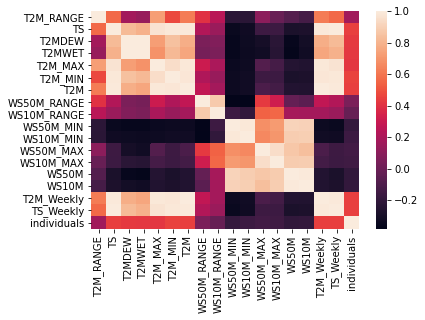

In [326]:
# Correlation Heatmap to identify correlation between the Series Data
corr = combined_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [328]:
two_feautre_df = combined_df[["T2M_Weekly","TS_Weekly","individuals"]]

In [329]:
two_feautre_df.shape

(105, 3)

In [330]:
train_set_m, test_set_m= np.split(two_feautre_df, [int(.80 *len(two_feautre_df))])

In [311]:
train_set_m["individuals"].shape

(84,)

In [313]:
test_set_m["T2M_Weekly"].shape

(21,)

## In diesem Abschnitt nutzen wir die wöchentlichen mean() Temperaturdaten als Exogene Variable 
- Multivariate

In [336]:
# Nutzung von durchschnitllicher wöchtentlicher Temperatur als exogene Variable
multivariate = SARIMAX(train_set_m["individuals"], exog = train_set_m["T2M_Weekly"], order = (2,1,0), seasonal_order=(0,0,0,6))

In [315]:
two_feautre_df["individuals"].shape


(105,)

In [ ]:
multivariate_fit = multivariate.fit(disp=False)
multivariate_fit.summary()

(417.3762824838587, 3.104786137502207e+17)

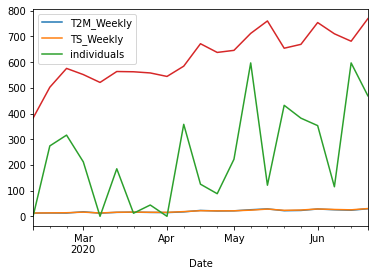

In [337]:
fit_plot_evaluate(multivariate,train_set_m["individuals"], test_set_m, test_set_m["TS_Weekly"])


In [ ]:
test = SARIMAX(train_set_m["individuals"], order = (2,1,0), seasonal_order=(0,0,0,12))

In [ ]:
fit_plot_evaluate(test,train_set_m["individuals"], test_set_m["individuals"])